# Data Loading and Quick Look at the Structure

In [1]:
import pandas as pd
import random

random.seed(42)      # We set the random seed to some constant number for reproducible results

train_data = pd.read_csv("vaccine_train_set.csv").drop(columns=["Unnamed: 0"])
validation_data = pd.read_csv("vaccine_validation_set.csv").drop(columns=["Unnamed: 0"])

In [2]:
train_data.head()    # 0 = Neutral, 1 = Anti-Vax, 2 = Pro-Vax

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


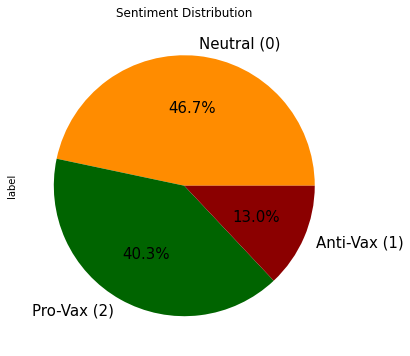

In [3]:
label_sentiments = {0: "Neutral (0)", 1: "Anti-Vax (1)", 2: "Pro-Vax (2)"}   # Make a dictionary mapping each label to its sentiment
plot = train_data['label'].value_counts().rename(index=label_sentiments).plot(kind='pie',figsize=(6,6), fontsize=15, colors=['darkorange','darkgreen','darkred'], title='Sentiment Distribution', autopct='%1.1f%%')

# Data Exploration

Let's see visualize the most frequent words in our training data.

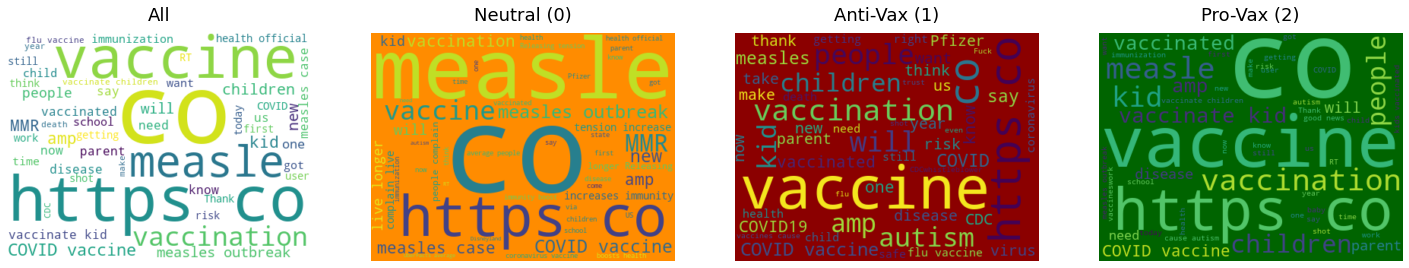

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

exploration_data = train_data.copy()    # Get a copy of the training data

all_tweets = " ".join(i for i in exploration_data['tweet'])
neutral_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 0])
negative_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 1])
positive_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 2])

wordcloud_all = WordCloud(max_words=50, height=300, background_color = 'white', stopwords = stopwords).generate(all_tweets)
wordcloud_neutral = WordCloud(max_words=50, height=300, background_color = 'darkorange', stopwords = stopwords).generate(neutral_tweets)
wordcloud_negative = WordCloud(max_words=50, height=300, background_color = 'darkred', stopwords = stopwords).generate(negative_tweets)
wordcloud_positive = WordCloud(max_words=50, height=300, background_color = 'darkgreen', stopwords = stopwords).generate(positive_tweets)

plt.figure(figsize = (25,30))
for i, wordcloud, title in [(1, wordcloud_all, 'All'), (2, wordcloud_neutral, 'Neutral (0)'), (3, wordcloud_negative, 'Anti-Vax (1)'), (4, wordcloud_positive, 'Pro-Vax (2)')]:
    plt.subplot(1,4,i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize = 18, y = 1.03)
    plt.axis("off")
plt.show()

The above visualizations don't look very informative. Firstly, there's a high overlap of individual words between the different categories. This is quite expected considering that even strong words like 'autism' can appear in both Anti-Vax and Pro-Vax tweets as 'vaccines cause autism' and 'vaccines don't cause autism' respectively, hence n-grams like bigrams would probably be much more informative than individual words. Secondly, there's quite some noise in our data, like links (https), that appear too often in our tweets and don't really offer any insights, therefore we'd probably have to clean our data before feeding them to our classification algorithms.

Now let's try to find and visualize the types of noise tweets can possibly have, like:
- tags (@)
- links (http,https,www)
- hashtags (some could be useful though)
- emojis
- emoticons :-)

In [5]:
import re
%pip install emoji
import emoji

def find_urls(tweet):
    """
    Searches for urls (http,https,www) in a tweet .
    """
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    return re.search(url_pattern,tweet)

def find_hashtags(tweet):
    """
    Searches for hashtags (#) in a tweet.
    """
    hashtag_pattern = re.compile(r'#(\w+)')
    return re.search(hashtag_pattern,tweet)

def find_tags(tweet):
    """
    Searches for tags (@) in a tweet.
    """
    tag_pattern = re.compile(r'@[^\s]+')
    return re.search(tag_pattern,tweet)

def find_emojis(tweet):
    """
    Searches for emojis in a tweet.
    """
    emoji_pattern = emoji.get_emoji_regexp()
    return re.search(emoji_pattern,tweet)

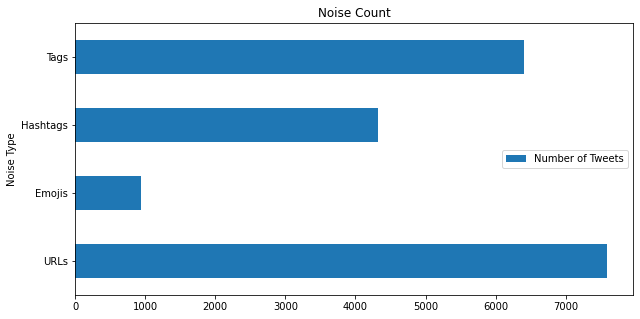

In [6]:
urls = exploration_data['tweet'].apply(find_urls).notnull().sum()
emojis = exploration_data['tweet'].apply(find_emojis).notnull().sum()
hashtags = exploration_data['tweet'].apply(find_hashtags).notnull().sum()
tags = exploration_data['tweet'].apply(find_tags).notnull().sum()
df_noise = pd.DataFrame({'Noise Type': ['URLs', 'Emojis', 'Hashtags', 'Tags'], 'Number of Tweets': [urls, emojis, hashtags,tags]})
df_noise.plot.barh(x='Noise Type', y='Number of Tweets',figsize=(10,5), title='Noise Count');

# Data Preparation

## (Task-Specific) Noise Removal

We create custom transformers for each preparation step in order to create preparation pipelines and later treat our preparation steps as hyperparameters for fine-tuning our best model.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class URLRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the urls from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the urls in all the tweets
            - None: Does nothing. No urls are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            url_pattern = re.compile(r'http\S+|www\S+|https\S+')
            return X_rem.apply(lambda tweet: url_pattern.sub(r'',tweet))
        return X
    
class HashtagRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the hashtags from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the hashtags in all the tweets.
            - None: Does nothing. No hashtags are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            hashtag_pattern = re.compile(r'#(\w+)')
            return X_rem.apply(lambda tweet: hashtag_pattern.sub(r'',tweet))
        return X

class TagRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the tags from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the tags in all the tweets.
            - None: Does nothing. No tags are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            tag_pattern = re.compile(r'@[^\s]+')
            return X_rem.apply(lambda tweet: tag_pattern.sub(r'',tweet))
        return X

class EmojiRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the emojis from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the emojis in all the tweets.
            - Convert: Converts all the emojis to their text representations.
            - None: Does nothing. No emojis are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            if self.strategy == 'Remove':
                emoji_pattern = emoji.get_emoji_regexp()
                return X_rem.apply(lambda tweet: emoji_pattern.sub(r'',tweet))
            elif self.strategy == 'Convert':
                return X_rem.apply(lambda tweet: emoji.demojize(tweet))
        return X

## Normalization

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
Stopwords = set(stopwords.words('english')) # We save them in this variable to speed up the lambda function for removing stopwords. It also helps speed up gridSearch later.
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

class LowercaseConverter(BaseEstimator, TransformerMixin):
    """
    Converts (or not) all tweets to lowercase.
    """
    def __init__(self, strategy='Convert'):
        """
        Available Strategies:
            - Convert: Converts all tweets to lowercase.
            - None: Does nothing. No lowercase conversion takes place.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            return X.str.lower()
        return X      

class PunctuationRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the punctuation from all tweets.
    (In fact, it replaces it with empty space which comes 
    in handy when we convert emojis to their text representations)
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the punctuation in all the tweets.
            - None: Does nothing. No punctuation is removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            punctuation_pattern = re.compile(r'[^\w\s]')
            return X_rem.apply(lambda tweet: punctuation_pattern.sub(r' ',tweet))
        return X
    
class StopwordRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the stopwords from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the stopwords in all the tweets.
            - None: Does nothing. No stopwords are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            return X.apply(lambda tweet: " ".join([word for word in str(tweet).split() if word not in Stopwords]))
        return X    
    
class InflectedFormHandler(BaseEstimator, TransformerMixin):
    """
    Handles the inflected forms of words by using either Stemming or Lemmatization.
    """
    def __init__(self, strategy='Stemming'):
        """
        Available Strategies:
            - Stemming: Uses a stemmer.
            - lemmatization: Uses a lemmatizer.
            - None: Does nothing. No inflected form handling takes place.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            if self.strategy == 'Stemming':
                return X.apply(lambda tweet: " ".join([stemmer.stem(word) for word in tweet.split()]))
            elif self.strategy == 'Lemmatization':
                return X.apply(lambda tweet: " ".join([lemmatizer.lemmatize(word, pos='v') for word in tweet.split()]))
        return X    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Vectorization

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

class Vectorizer(BaseEstimator, TransformerMixin):
    """
    Vectorizes the data using either Bag of Words or TF-IDF.
    """
    def __init__(self, strategy='BoW', ngram_range=(1,1), min_df=1, max_df=1.0):
        """
        Available Strategies:
            - BoW: Bag of Words.
            - TF-IDF: TF-IDF.
        ngrams: the ngram_range parameter e.g. ngrams=(1, 1)=only unigrams, (1, 2)=unigrams and bigrams
        min_df: minimum number of tweets a word must be present in to be considered a feature
        max_df: maximum number of tweets a word can be present in to be considered a feature
        """
        self.strategy = strategy
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.max_df = max_df
        self.vectorizer = None
    def fit(self, X, y=None):
        """
        Initiates the vectorizer to the chosen method (bow or tfidf) and then only fits the vectorizer 
        on the data (no transform). This way we can 'fit_transform' on the training data and only call 
        'transform' on the validation data.
        """
        if self.strategy == 'BoW':
            self.vectorizer = CountVectorizer(analyzer='word', ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
        elif self.strategy == 'TF-IDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
        self.vectorizer.fit(X)
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the data using the -already fit- vectorizer of the class.
        """
        X_vec = X.copy()
        return self.vectorizer.transform(X_vec)

# Model Selection and Training

Let's train various models with varying preparation steps and model parameters (depending on our intuition at first) and then plot their learning curves to see if they're overfitting/underfitting out data.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(preparation_pipeline, classification_model, plot_title):
    """
    Trains on various sizes of the training set using the preparation pipeline
    and classification model passed as arguments and then, for each training sample,
    plots the f1_score computed on the (full) validation set.  
    """
    # Set the training sample sizes
    train_sizes = np.arange(100,len(train_data),1500)
    train_sizes = np.append(train_sizes,len(train_data))                                                     # Add the size of the whole training set as well
    
    train_f1_scores = []
    validation_f1_scores = []
    for train_size in train_sizes:
        X_train = train_data.copy()['tweet'][:train_size]
        y_train = train_data.copy()['label'][:train_size]
        
        # The validation data size is constant throughout the multiple trainings
        X_validation = validation_data.copy()['tweet']
        y_validation = validation_data.copy()['label']        
        
        # Preprocess the (sample) training and (full) validation using the pipeline
        try:
            # A high min_df value in the vectorizer combined with too few training examples can result in 0 features and raise a ValueError
            X_train = preparation_pipeline.fit_transform(X_train)
        except ValueError:
            train_f1_scores.append(0)
            validation_f1_scores.append(0)
            continue
        X_validation = preparation_pipeline.transform(X_validation)                                          # No fit
        
        # Fit the model on the training data
        classification_model.fit(X_train, y_train);
        
        # Make predictions on the validation set
        predictions_train = classification_model.predict(X_train)
        predictions_validation = classification_model.predict(X_validation)
        
        # Save the (weighted average) f1_scores
        train_f1_scores.append(f1_score(y_train, predictions_train, average='weighted', zero_division=0))
        validation_f1_scores.append(f1_score(y_validation, predictions_validation, average='weighted', zero_division=0))
        
    # Plot the (weighted average) f1_scores
    plt.plot(train_sizes, train_f1_scores, label = 'Training')
    plt.plot(train_sizes, validation_f1_scores, label = 'Validation')
    plt.ylabel('F1 Score (Weighted Average)', fontsize = 12)
    plt.xlabel('Training Set Size', fontsize = 12)
    plt.title(plot_title, fontsize = 18, y = 1.03)
    plt.legend()

Let's see how the **Regularization Parameter C** of our model affects our generalization.

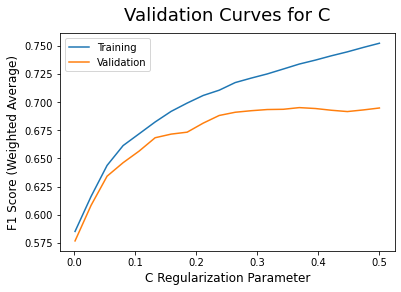

In [11]:
# We try our default parameters for the preparation pipeline. We'll fine tune it later.
preparation_pipeline = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover()),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover()),
        ('inflected_forms', InflectedFormHandler()),
        ('vectorization', Vectorizer())
    ])
    
X_train = train_data.copy()['tweet']
y_train = train_data.copy()['label']
X_validation = validation_data.copy()['tweet']
y_validation = validation_data.copy()['label']     

# Preprocess the data
X_train = preparation_pipeline.fit_transform(X_train)
X_validation = preparation_pipeline.transform(X_validation)

c_params = np.linspace(0.001,0.5,20)
train_f1_scores = []
validation_f1_scores = []
for c in c_params:       
    # Fit the model on the training data
    classification_model = LogisticRegression(multi_class="multinomial",solver="saga", C=c, penalty='l1', max_iter=1000, tol=0.001)
    classification_model.fit(X_train, y_train);

    # Make predictions on the validation set
    predictions_train = classification_model.predict(X_train)
    predictions_validation = classification_model.predict(X_validation)

    # Save the (weighted average) f1_scores
    train_f1_scores.append(f1_score(y_train, predictions_train, average='weighted', zero_division=0))
    validation_f1_scores.append(f1_score(y_validation, predictions_validation, average='weighted', zero_division=0))

# Plot the (weighted average) f1_scores
plt.plot(c_params, train_f1_scores, label = 'Training')
plt.plot(c_params, validation_f1_scores, label = 'Validation')
plt.ylabel('F1 Score (Weighted Average)', fontsize = 12)
plt.xlabel('C Regularization Parameter', fontsize = 12)
plt.title("Validation Curves for C", fontsize = 18, y = 1.03)
plt.legend()

It looks like a good value for the regularization parameter C lies somewhere between 0.01 and 0.15. Giving our model more freedom by incresing the value of C results in increasing the variance of our model and hurting its generalization abilities. However, the optimal value probably depends on our chosen data preprocessing steps as well.

Let's see how the **Vectorization** process **ngram_range** parameter affects our generalization.

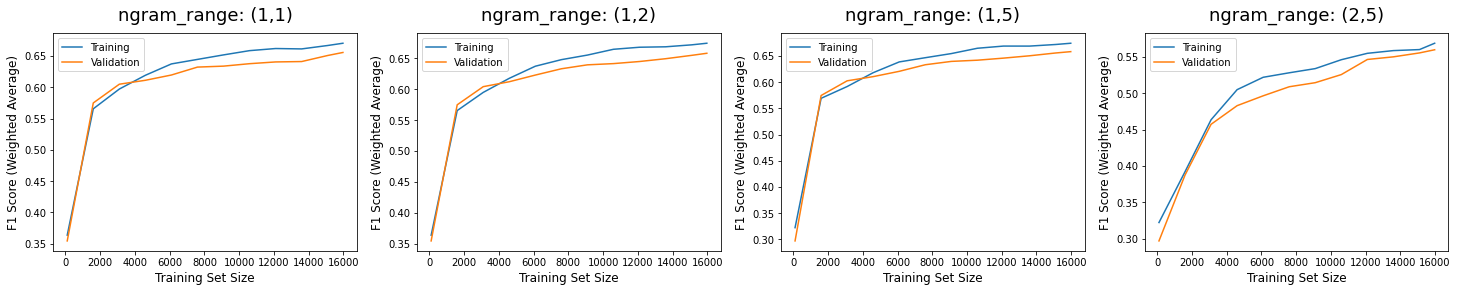

In [12]:
pp1 = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover()),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover()),
        ('inflected_forms', InflectedFormHandler()),
        ('vectorization', Vectorizer(ngram_range=(1,1)))
    ])

pp2 = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover()),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover()),
        ('inflected_forms', InflectedFormHandler()),
        ('vectorization', Vectorizer(ngram_range=(1,2)))
    ])

pp3 = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover()),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover()),
        ('inflected_forms', InflectedFormHandler()),
        ('vectorization', Vectorizer(ngram_range=(1,6)))
    ])

pp4 = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover()),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover()),
        ('inflected_forms', InflectedFormHandler()),
        ('vectorization', Vectorizer(ngram_range=(2,6)))
    ])

softmax_reg = LogisticRegression(multi_class="multinomial",solver="saga", C=0.1, penalty='l1', max_iter=1000, tol=0.001)

plt.figure(figsize = (25,4))
for preparation_pipeline, i, plot_title in [(pp1, 1, 'ngram_range: (1,1)'), (pp2, 2, 'ngram_range: (1,2)'), (pp3, 3, 'ngram_range: (1,5)'), (pp4, 4, 'ngram_range: (2,5)')]:
    plt.subplot(1,4,i)
    plot_learning_curves(preparation_pipeline, softmax_reg, plot_title)

It looks like increasing the number of n-grams decreases the bias of our model and allows it to fit our training data better. However, increasing the number of n-grams too much ends up increasing the variance of our model and, therefore, our model starts to overfit our training data (which is expected to happen because a very high number of n-grams means an explosion of features). Excluding the unigrams leads to a decrease in the variance but also an increase in bias which, as a result, results in a poor f1_score. We think that the best choice would probably be to use more than unigrams (unigrams and bigrams or also trigrams) but also not exclude them from the features and then tame the increase in the variance caused by the high number of features using the min_df parameter of our vectorizer.

P.S. The results don't look that different because the regularization parameter C of LogisticRegression is already constraining our model enough to not overfit. Obviously, without a higher value for C (more freedom for the model), increasing the number of n_grams gives our model more ways to decrease the bias and possibly overfit given a very high value.

Let's see how the **Vectorization** process **mid_df** parameter affects our generalization.

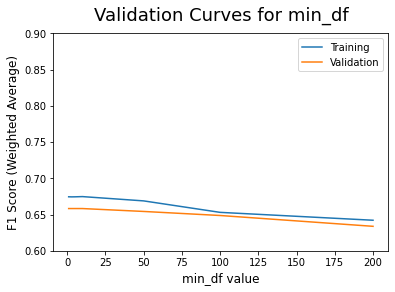

In [13]:
min_dfs = [1,3,5,10,50,100, 200]
train_f1_scores = []
validation_f1_scores = []
for min_df_value in min_dfs:       
    X_train = train_data.copy()['tweet']
    y_train = train_data.copy()['label']
    X_validation = validation_data.copy()['tweet']
    y_validation = validation_data.copy()['label']   

    preparation_pipeline = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover()),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover()),
        ('inflected_forms', InflectedFormHandler()),
        ('vectorization', Vectorizer(ngram_range=(1,3),min_df=min_df_value))
    ])  

    # Preprocess the data
    X_train = preparation_pipeline.fit_transform(X_train)
    X_validation = preparation_pipeline.transform(X_validation)

    # Fit the model on the training data
    classification_model = LogisticRegression(multi_class="multinomial",solver="saga", C=0.1, penalty='l1', max_iter=1000, tol=0.001)
    classification_model.fit(X_train, y_train);

    # Make predictions on the validation set
    predictions_train = classification_model.predict(X_train)
    predictions_validation = classification_model.predict(X_validation)

    # Save the (weighted average) f1_scores
    train_f1_scores.append(f1_score(y_train, predictions_train, average='weighted', zero_division=0))
    validation_f1_scores.append(f1_score(y_validation, predictions_validation, average='weighted', zero_division=0))

# Plot the (weighted average) f1_scores
plt.plot(min_dfs, train_f1_scores, label = 'Training')
plt.plot(min_dfs, validation_f1_scores, label = 'Validation')
plt.ylabel('F1 Score (Weighted Average)', fontsize = 12)
plt.xlabel('min_df value', fontsize = 12)
plt.ylim(0.6, 0.9)
plt.title("Validation Curves for min_df", fontsize = 18, y = 1.03)
plt.legend()

As expected, considering all n-grams as features no matter how often they appear in the tweets leads to some overfitting on the training data. This huge number of features that we end up with negatively affects our generalization. It's better to constraint the number of features using a higher value for the min_df parameter on the vectorizer, thereby keeping only the words that appear at least 'min_df' times in our data. As a result, this reduces the number of features in our data and leads to better generalization. 

Increasing n_grams leads to smaller variance up to a certain point after which the variance increases again (probably because the remaining features are too few to lead to any good predictions). It also leads to higher bias since f1_scores decrease. We would like to find a balance between these two. 

Let's see how the **Vectorizer Strategy** affects our generalization.

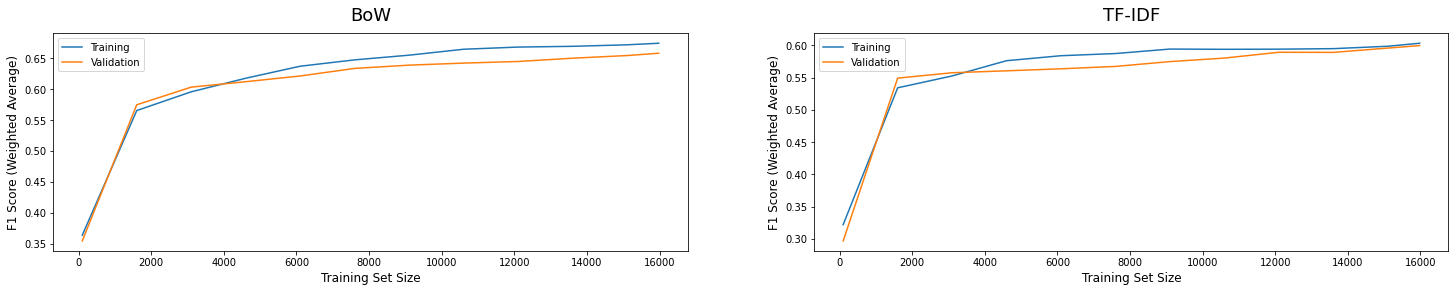

In [14]:
pp1 = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover()),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover()),
        ('inflected_forms', InflectedFormHandler()),
        ('vectorization', Vectorizer(strategy='BoW', ngram_range=(1,3), min_df=5))
    ])

pp2 = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover()),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover()),
        ('inflected_forms', InflectedFormHandler()),
        ('vectorization', Vectorizer(strategy='TF-IDF', ngram_range=(1,3), min_df=5))
    ])

softmax_reg = LogisticRegression(multi_class="multinomial",solver="saga", C=0.1, penalty='l1', max_iter=1000, tol=0.001)

plt.figure(figsize = (25,4))
for preparation_pipeline, i, plot_title in [(pp1, 1, 'BoW'), (pp2, 2, 'TF-IDF')]:
    plt.subplot(1,2,i)
    plot_learning_curves(preparation_pipeline, softmax_reg, plot_title)

It seems that, given our already chosen paramaters for the preparation and the classification model, the plain Bag of Words method leads to better f1_scores (lower bias) but a little larger variance than TF-IDF. Choosing between the two depends on whether we consider the variance in Bag of Words significant enough to go with the lower variance TF-IDF model.

We're quite confident that other preparation step parameters (e.g. removing/converting emojis, removing/keeping stopwords and BoW/TF-IDF for vectorization) won't **dramatically** change our model's generalization either. However, we will indeed fine-tune these parameters as well when we do data fine-tuning using GridSearchCV.

For now, let's do some error analysis on our best model so far to get a taste of its strengths and weaknesses as per the generalization on the validation set!

# Error Analysis

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_validation,predictions_validation):
    normalized_confusion_matrix = confusion_matrix(y_validation, predictions_validation) / confusion_matrix(y_validation, predictions_validation).sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(normalized_confusion_matrix, annot=True, cmap=plt.cm.gray, xticklabels=label_sentiments.values(), yticklabels=label_sentiments.values())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Validation Confusion Matrix')
    plt.show()
    
def print_wrong_examples(y_validation,predictions_validation):
    normalized_confusion_matrix = confusion_matrix(y_validation, predictions_validation) / confusion_matrix(y_validation, predictions_validation).sum(axis=1, keepdims=True)
    print("Examples of Wrong Classification in Validation:\n")
    for actual in label_sentiments.keys():
      for predicted in label_sentiments.keys():
        if actual != predicted and normalized_confusion_matrix[actual, predicted] > 0.2:       # Print only examples of label pairs with >20% confusion rate in the matrix
            print(f"\n'{label_sentiments[actual]}' Predicted as '{label_sentiments[predicted]}' - {round(100*normalized_confusion_matrix[actual, predicted])}% Confusion Rate:\n")
            for index,row in validation_data.loc[(y_validation == actual) & (predictions_validation == predicted)].head().iterrows():
                print(f"Index: {index} - Tweet: {row['tweet']}")
                
def print_top_ngrams(preparation_pipeline, model, N=6):         
    """
    Prints the most top N most correlated n-grams for each of the labels.
    (according to the learned θ parameters of the classification model)
    preparation_pipeline = The pipeline used to preprocess the data
                          (we need this for the ngrams used and the
                          feature_names of the vectorizer)
    model = This is the softmax regression model whose θ parameters we use
            to find the top n-grams
    N = The number of top n-grams to print e.g. the top 6 uni-grams and bi-grams
    """
    vectorizer = preparation_pipeline['vectorization'].vectorizer          # Get the vectorizer instance from the pipeline
    ngram_range = preparation_pipeline['vectorization'].ngram_range        # Get the value of the ngrams parameter in pipeline's vectorizer
    for label in label_sentiments.keys():
        indices = np.argsort(model.coef_[label])                           # Sort the model's learned coefficients θ (for each label) from lowest to highest and get their -indices-
        feature_names = np.array(vectorizer.get_feature_names())[indices]  # Get the words themselves (from the chosen vectorizer) corresponding to each index/coefficient
        print(f"\nIn '{label_sentiments[label]}' Tweets:")
        for n in range(ngram_range[0],ngram_range[1]+1):                   # Convert the ngram_range tuple to a range of numbers e.g. (1,3) = 1,2,3
            n_grams = [v for v in reversed(feature_names) if len(v.split(' ')) == n][:N]
            print("  Top {}-grams:\n      - {}".format(n,'\n      - '.join(n_grams))) 

Let's train our best model and do some predictions on the validation set with it.

In [16]:
preparation_pipeline = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover()),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover()),
        ('inflected_forms', InflectedFormHandler()),
        ('vectorization', Vectorizer(strategy='BoW', ngram_range=(1,3), min_df=5))
    ])

X_train = train_data.copy()['tweet']
y_train = train_data.copy()['label']
X_validation = validation_data.copy()['tweet']
y_validation = validation_data.copy()['label']

# Preprocess our data
X_train = preparation_pipeline.fit_transform(X_train)
X_validation = preparation_pipeline.transform(X_validation)

# Fit the classification model on the training data
softmax_reg = LogisticRegression(multi_class="multinomial",solver="saga", C=0.1, penalty='l1', max_iter=1000, tol=0.001)
softmax_reg.fit(X_train, y_train)

# Predict on the validation set
predictions_validation = softmax_reg.predict(X_validation)

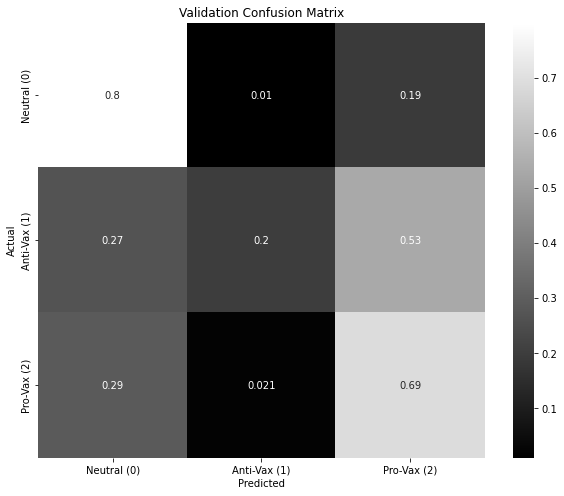

In [17]:
plot_confusion_matrix(y_validation,predictions_validation)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_validation, predictions_validation))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      1065
           1       0.66      0.20      0.31       296
           2       0.64      0.69      0.66       921

    accuracy                           0.68      2282
   macro avg       0.67      0.56      0.57      2282
weighted avg       0.68      0.68      0.66      2282



It looks like our model is doing quite fine on the Neutral (0) and Pro-Vax (2) tweets but not that good on the Anti-Vax (1) ones. When our model claims that a tweet is Anti-Vax (1) it is correct about 66% percent of the time (fine precision). However, it only detects 20% of the actual Anti-Vax (1) tweets (low recall). Obviously, this difference in precision and recall for the Anti-Vax (1) class results in a mediocre f1-score.

On some level, it is expected from our model to perform poorly on the Anti-Vax (1) class, because this class is the rarest one. The training dataset is skewed and already small enough, which affects the training process. 

Let's see some mistakes of wrong classification from our model and print top n-grams found for each label.

In [19]:
print_wrong_examples(y_validation,predictions_validation)

Examples of Wrong Classification in Validation:


'Anti-Vax (1)' Predicted as 'Neutral (0)' - 27% Confusion Rate:

Index: 42 - Tweet: “@NFIDvaccines: Beware: NYC hospitals don't make health workers get #vaccinated http://t.co/YyknLo7VK4 via @nypost” excellent article
Index: 51 - Tweet: In the CDC we blindly trust, right? #CDCwhistleblower #BlackLivesMatter #vaccineworks #autism #SB277 @JerryBrownGov http://t.co/8WKOD7wiZK
Index: 53 - Tweet: @4chunat1 Don't forget these disease infested people have Drug resistant TB, measles, Mersa and much more. Kirsten Powers  Pelosi want them
Index: 59 - Tweet: Health Officials In Delaware Valley Highlight Importance Of Measles Vaccine: With one potential case of measles in… http://t.co/BmGgi9Bh6V
Index: 78 - Tweet: MT @viciousbabushka: Don't Tread On Measles #tcot #UniteBlue #vaccinations #vaccines #AntiVaxxer @milesjreed http://t.co/yOjufUaPmr

'Anti-Vax (1)' Predicted as 'Pro-Vax (2)' - 53% Confusion Rate:

Index: 0 - Tweet: @user They had a massi

In [20]:
print_top_ngrams(preparation_pipeline=preparation_pipeline, model=softmax_reg, N=4)         


In 'Neutral (0)' Tweets:
  Top 1-grams:
      - mmr
      - boost
      - updat
      - measl
  Top 2-grams:
      - increas immun
      - 19 vaccin
      - coronaviru vaccin
      - live longer
  Top 3-grams:
      - covid 19 vaccin
      - gave input measl
      - get flu shot
      - get flu vaccin

In 'Anti-Vax (1)' Tweets:
  Top 1-grams:
      - injur
      - 99
      - dna
      - injuri
  Top 2-grams:
      - immun system
      - take vaccin
      - guinea pig
      - gener popul
  Top 3-grams:
      - florida depart health
      - flu get vaccin
      - gave input measl
      - get flu shot

In 'Pro-Vax (2)' Tweets:
  Top 1-grams:
      - prevent
      - anti
      - save
      - hope
  Top 2-grams:
      - good news
      - great news
      - vaccin kid
      - anti vaxxer
  Top 3-grams:
      - get autism vaccin
      - get covid vaccin
      - get covid 19
      - get children vaccin


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Increasing the value of the regularization parameter C would give our model some more freedom when fitting the training set and result in better predictions. However, we can't increase it too much because, as shown previously, after C=0.15 we start to overfit our data and the generalization error becomes too big (even though the predictions seem to have improved).

Before changing the value of C, let's see whether **fine-tuning** the parameters for our **other preparation steps** can give us some boosting on their own. 

# Fine-Tuning

In [21]:
from sklearn.model_selection import PredefinedSplit

def predefined_split(train_data,validation_data):
    """
    This function concatenates the X's and the y's of the training and the validation set and
    then creates a PredefinedSplit instance to use as the 'cv' parameter when fine-tuning.
    We perform GridSearch and RandomizedSearch to fine-tune the data preparation steps and the
    classification model respectively. The problem is that we already have a -predefined- 
    validation set according to which we want to find the best parameters when fine-tuning
    (we don't want GridSearch and RandomizedSearch to split the training set into two sets
    -again- when using cross-validation).
    In order to achieve this, we need dataframes with the X's and the y's of both sets but keep
    the training and the validation constant during searching (i.e. set the 'cv' parameter of 
    GridSearch and RandomizedSearch such that it knows which indices correspond to training only
    and which to validation only).
    
    Note: We didn't do that previously when training our models, because there was no need for it.
    We didn't use any cross validation method previously (because our sets are already split) so 
    there was no need to use PredefinedSplit.
    """
    train = train_data.copy()
    val = validation_data.copy()
    
    # Concatenate the X's and the y's of the training and the validation set
    X_both = pd.concat([train['tweet'],val['tweet']],axis=0,ignore_index=True)
    y_both = pd.concat([train['label'],val['label']],axis=0,ignore_index=True)
    
    # Create a list where train data indices are -1 and validation data indices are 0
    # See https://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets for why these numbers
    split_index = [-1 if x in train.index else 0 for x in X_both.index]

    # Use the list to create PredefinedSplit
    pds = PredefinedSplit(test_fold = split_index)
    
    return X_both, y_both, pds

def get_best_pipeline(preparation_best_params: dict) -> Pipeline:
    """
    This function creates a Pipeline according to the best 
    parameters found with grid_search when fine-tuning the data
    (i.e. treating the preparation steps as hyperparameters).
    """
    best_pipeline = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover(strategy=preparation_best_params['emojis__strategy'])),   # Set the EmojiRemover strategy to the grid search's best 
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover(strategy=preparation_best_params['stopwords__strategy'])),
        ('inflected_forms', InflectedFormHandler(strategy=preparation_best_params['inflected_forms__strategy'])),
        ('vectorization', Vectorizer(strategy=preparation_best_params['vectorization__strategy'], ngram_range=preparation_best_params['vectorization__ngram_range'], min_df=preparation_best_params['vectorization__min_df']))  
    ])
    # Note, when the best params are the default ones of the corresponding transformers, they're not shown when printing the pipeline (only the non-default are shown)
    return best_pipeline

## Data Fine-Tuning
Treating the preparation steps as hyperparameters

In [22]:
from sklearn.model_selection import GridSearchCV

preparation_grid = [{
    'emojis__strategy':           ['Remove','Convert'],
    'stopwords__strategy':        [None, 'Remove'],
    'inflected_forms__strategy':  ['Stemming', 'Lemmatization'],
    'vectorization__strategy':    ['BoW','TF-IDF'],
    'vectorization__ngram_range': [(1,2),(1,3)],
    'vectorization__min_df':      [5] 
}]

preparation_plus_prediction_pipeline = Pipeline([
    ('urls', URLRemover()),
    ('hashtags', HashtagRemover()),
    ('tags', TagRemover()),
    ('emojis', EmojiRemover()),
    ('lowercase', LowercaseConverter()),
    ('punctuation', PunctuationRemover()),
    ('stopwords', StopwordRemover()),
    ('inflected_forms', InflectedFormHandler()),
    ('vectorization', Vectorizer()),
    ('prediction', LogisticRegression(multi_class="multinomial",solver="saga", C=0.1, penalty='l1', max_iter=1000, tol=0.001))
])

# We don't actually train on both datasets, the validation part of X_both is constantly used for -validation- in GridSearch
X_both, y_both, pds = predefined_split(train_data,validation_data)

softmax_pppp_grid_search = GridSearchCV(preparation_plus_prediction_pipeline, preparation_grid, cv=pds, scoring='f1_weighted', n_jobs=-1, verbose=1) #scoring='neg_log_loss'
softmax_pppp_grid_search.fit(X_both, y_both)

Fitting 1 folds for each of 32 candidates, totalling 32 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('urls', URLRemover()),
                                       ('hashtags', HashtagRemover()),
                                       ('tags', TagRemover()),
                                       ('emojis', EmojiRemover()),
                                       ('lowercase', LowercaseConverter()),
                                       ('punctuation', PunctuationRemover()),
                                       ('stopwords', StopwordRemover()),
                                       ('inflected_forms',
                                        InflectedFormHandler()),
                                       ('vectoriza...
                                                           multi_class='multinomial',
                                                           penalty='l1',
                                                           solver='saga',
                         

In [23]:
print('Best Parameters: ', softmax_pppp_grid_search.best_params_)
print('Best F1_Score: ', softmax_pppp_grid_search.best_score_)

Best Parameters:  {'emojis__strategy': 'Remove', 'inflected_forms__strategy': 'Lemmatization', 'stopwords__strategy': None, 'vectorization__min_df': 5, 'vectorization__ngram_range': (1, 2), 'vectorization__strategy': 'BoW'}
Best F1_Score:  0.6805736742601487


Let's train a model with the fine-tuned preparation steps to see if we made any improvement.

In [24]:
# Copy the data
X_train = train_data.copy()['tweet']
y_train = train_data.copy()['label']
X_validation = validation_data.copy()['tweet']
y_validation = validation_data.copy()['label']

# Preprocess the data
best_preparation_pipeline = get_best_pipeline(softmax_pppp_grid_search.best_params_)            # Create a pipeline using the best preparation steps found above
X_train = best_preparation_pipeline.fit_transform(X_train)
X_validation = best_preparation_pipeline.transform(X_validation)

# Fit the classification model on the training data
softmax_reg = LogisticRegression(multi_class="multinomial",solver="saga", C=0.1, penalty='l1', max_iter=1000, tol=0.001)
softmax_reg.fit(X_train, y_train)

# Predict on the validation set
predictions_validation = softmax_reg.predict(X_validation)

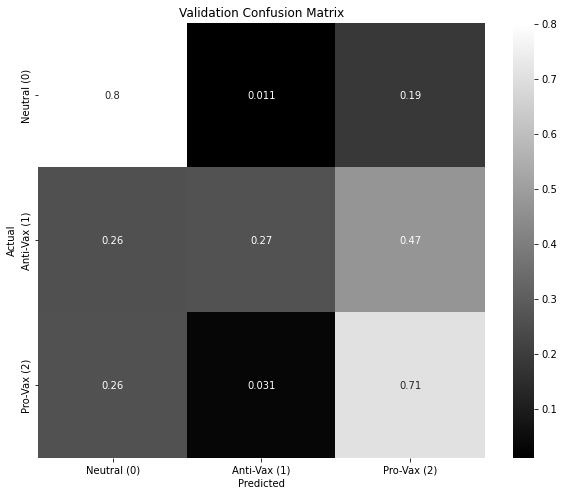

In [25]:
plot_confusion_matrix(y_validation,predictions_validation)

In [26]:
print(classification_report(y_validation, predictions_validation))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1065
           1       0.66      0.27      0.38       296
           2       0.66      0.71      0.68       921

    accuracy                           0.69      2282
   macro avg       0.68      0.59      0.61      2282
weighted avg       0.69      0.69      0.68      2282



Now, let's plot the learning curve for our model with the best preparation pipeline to see whether it overfits/underfits our training data.

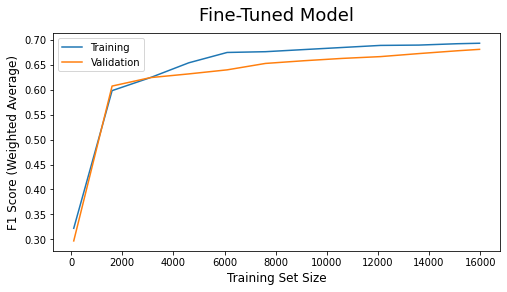

In [27]:
plt.figure(figsize = (8,4))
softmax_reg = LogisticRegression(multi_class="multinomial",solver="saga", C=0.1, penalty='l1', max_iter=1000, tol=0.001)
plot_learning_curves(best_preparation_pipeline, softmax_reg, 'Fine-Tuned Model')

It looks like we achieved a slightly better f1_score by these added preparation steps, but not a dramatic difference after all, and we did that without hurting the generalization of our model.

Now, we could either deploy this particular model or try to **fine-tune** the model's **regularization parameter** (or even other training parameters if we want) to try increase our f1_scores even further without increasing the variance too much (therefore, C would still have to lie somewhere between 0.05 and 0.15). Either case is fine and we don't really expect to see a dramatic decrease in bias neither a dramatic increase in variance because of the model fine-tuning.

## Model Fine-Tuning

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from scipy.sparse import vstack

# Treat preparation steps as hyperparameters
softmax_parameter_distributions = {
    'solver': ['saga'],
    'penalty': ['l1'],
    'C': loguniform(0.05, 0.15),
    'max_iter': [1000]
}

# Get the indices from PredifinedSplit before preprocessing the data because afterwards they're converted to scipy sparse matrices
X_both, y_both, pds = predefined_split(train_data,validation_data)

# Get the training and validation tweets in different variables because don't want to 'fit' the preparation pipeline on both sets
X_train = X_both[:len(train_data)]
X_validation = X_both[len(train_data):len(train_data)+len(validation_data)]

# Preprocess the tweets in the two using the best preparation steps found with GridSearch above
best_preparation_pipeline = get_best_pipeline(softmax_pppp_grid_search.best_params_)            # Create a pipeline using the best preparation steps found above
X_train = best_preparation_pipeline.fit_transform(X_train)                                      # fit-transform on the training set
X_validation = best_preparation_pipeline.transform(X_validation)                                # only transform on the validation set (no fit)

# Now concatenate the two scipy sparce matrices the same way they were concatenated before preparation (i.e. vertically, first train, then validation)
X_both = vstack((X_train, X_validation))

softmax_reg = LogisticRegression()
softmax_rnd_search = RandomizedSearchCV(softmax_reg, param_distributions=softmax_parameter_distributions, n_iter=20, cv=pds, scoring='f1_weighted', verbose=1, n_jobs=-1)
softmax_rnd_search.fit(X_both, y_both)

Fitting 1 folds for each of 20 candidates, totalling 20 fits


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7dfc3aae10>,
                                        'max_iter': [1000], 'penalty': ['l1'],
                                        'solver': ['saga']},
                   scoring='f1_weighted', verbose=1)

In [29]:
print('Best Parameters: ',softmax_rnd_search.best_params_)
print('Best F1_Score: ', softmax_rnd_search.best_score_)
print('Best Model: ', softmax_rnd_search.best_estimator_)

Best Parameters:  {'C': 0.1383890348496864, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best F1_Score:  0.6976496627736933
Best Model:  LogisticRegression(C=0.1383890348496864, max_iter=1000, penalty='l1',
                   solver='saga')


Let's print our model's top (most-correlated with the output label) n-grams per class to see if there's any difference. 

In [30]:
print_top_ngrams(preparation_pipeline=best_preparation_pipeline, model=softmax_rnd_search.best_estimator_, N=5)     


In 'Neutral (0)' Tweets:
  Top 1-grams:
      - immunity
      - mmr
      - coronavirus
      - madhatterdc
      - measles
  Top 2-grams:
      - immunity and
      - 19 vaccines
      - more than
      - this year
      - 19 vaccine

In 'Anti-Vax (1)' Tweets:
  Top 1-grams:
      - injure
      - 99
      - admit
      - injury
      - skeptical
  Top 2-grams:
      - no thank
      - guinea pig
      - any vaccine
      - not take
      - my son

In 'Pro-Vax (2)' Tweets:
  Top 1-grams:
      - herd
      - preventable
      - immunization
      - idiots
      - immunize
  Top 2-grams:
      - great news
      - no link
      - good news
      - not cause
      - vaccinate your


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Note**: There's no point in evaluating on the validation set any further, because after RandomizedSearch finished, it re-fitted our model on the whole dataset (X_both, y_both).
That is, on both the training and validation data. Therefore, since we've seen the validation data during training, there's no point in making any further predictions on them. (However, you can see the top n-grams of this final model below, before changing the path of the validation dataset to the test set's one. They look pretty reasonable.)

P.S. it's good that we re-trained on the whole dataset, because training with more data is probably better and, after all, the test set used for the final evaluation isn't affected by this.

# Final Model Evaluation on the Test Set

In [31]:
test_preparation_pipeline = best_preparation_pipeline        # Best preparation steps found with GridSearch
final_model = softmax_rnd_search.best_estimator_             # Best softmax regression model found with RandomizedSearch 

In [32]:
# Get the test data (-------> change this to the path of the test dataset <--------)
test_data = pd.read_csv("vaccine_validation_set.csv").drop(columns=["Unnamed: 0"])
X_test = test_data.copy()['tweet']
y_test = test_data.copy()['label']

# Preprocess the test tweets. Only transform (using the best parameters) found during training. No fit.
X_test = test_preparation_pipeline.transform(X_test)

# Predict on the (preprocessed) test set
predictions_test = final_model.predict(X_test)

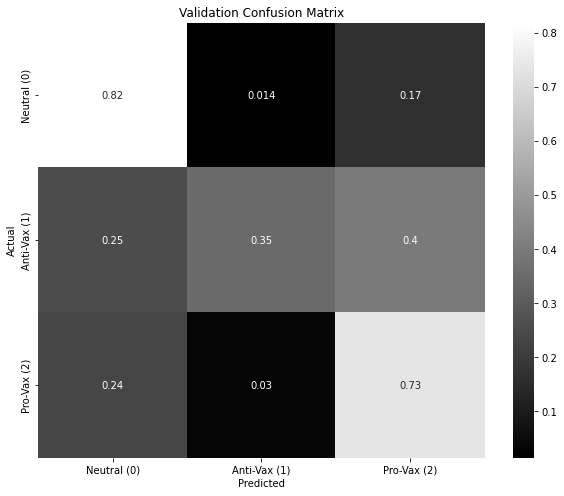

In [33]:
plot_confusion_matrix(y_test,predictions_test)

In [34]:
print_wrong_examples(y_test,predictions_test)

Examples of Wrong Classification in Validation:


'Anti-Vax (1)' Predicted as 'Neutral (0)' - 25% Confusion Rate:

Index: 42 - Tweet: “@NFIDvaccines: Beware: NYC hospitals don't make health workers get #vaccinated http://t.co/YyknLo7VK4 via @nypost” excellent article
Index: 51 - Tweet: In the CDC we blindly trust, right? #CDCwhistleblower #BlackLivesMatter #vaccineworks #autism #SB277 @JerryBrownGov http://t.co/8WKOD7wiZK
Index: 53 - Tweet: @4chunat1 Don't forget these disease infested people have Drug resistant TB, measles, Mersa and much more. Kirsten Powers  Pelosi want them
Index: 59 - Tweet: Health Officials In Delaware Valley Highlight Importance Of Measles Vaccine: With one potential case of measles in… http://t.co/BmGgi9Bh6V
Index: 78 - Tweet: MT @viciousbabushka: Don't Tread On Measles #tcot #UniteBlue #vaccinations #vaccines #AntiVaxxer @milesjreed http://t.co/yOjufUaPmr

'Anti-Vax (1)' Predicted as 'Pro-Vax (2)' - 40% Confusion Rate:

Index: 19 - Tweet: @BestInFlightLDJ @g33

In [35]:
print_top_ngrams(preparation_pipeline=test_preparation_pipeline, model=final_model, N=6)


In 'Neutral (0)' Tweets:
  Top 1-grams:
      - immunity
      - mmr
      - coronavirus
      - madhatterdc
      - measles
      - disneyland
  Top 2-grams:
      - immunity and
      - 19 vaccines
      - more than
      - this year
      - 19 vaccine
      - the measles

In 'Anti-Vax (1)' Tweets:
  Top 1-grams:
      - injure
      - 99
      - admit
      - injury
      - skeptical
      - force
  Top 2-grams:
      - no thank
      - guinea pig
      - any vaccine
      - not take
      - my son
      - that vaccine

In 'Pro-Vax (2)' Tweets:
  Top 1-grams:
      - herd
      - preventable
      - immunization
      - idiots
      - immunize
      - vein
  Top 2-grams:
      - great news
      - no link
      - good news
      - not cause
      - vaccinate your
      - get my


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1065
           1       0.71      0.35      0.47       296
           2       0.70      0.73      0.71       921

    accuracy                           0.72      2282
   macro avg       0.72      0.63      0.65      2282
weighted avg       0.72      0.72      0.71      2282

